# Data description & Problem statement: 
I will use the Yelp Review Data Set from Kaggle. Each observation in this dataset is a review of a particular business by a particular user. The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review. The "cool" column is the number of "cool" votes this review received from other Yelp users. The "useful" and "funny" columns are similar to the "cool" column. The goal of this project is to predict whether the customer will rate the business as GOOD or BAD.


# Workflow:
- Load the training and test datasets
- Data cleaning (e.g. remove formats and punctuations)
- Basic data exploration
- Text vectorization, using "Bag of Words" technique
- Use "tf-idf transformation", and find the "N-grams" to improve the model performace
- Use a supervised classifier (e.g. Logistic Regression, Naive Bayes, etc.) for text classification: Use Grid-Serach along with Cross-Validation technique for finding the optimal hyper-parameters of best classifier
- Evaluate the performance of best classifier on the test data set, by calculating:
     - f1, Precision, Recall scores
     - Confusion matrix
     - ROC curve

In [1]:
import sklearn
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# we insatll and import spacy package for some advanced tokenizaion techniques:
import spacy

# we also install and import mglearn package (using !pip install mglearn) for some interesting visualization of results:
import mglearn

In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is 3EA9-93A4

 Directory of C:\Users\rhash\Documents\Datasets\NLP projects (sklearn & Spark)

12/29/2018  08:34 PM    <DIR>          .
12/29/2018  08:34 PM    <DIR>          ..
12/29/2018  08:33 PM    <DIR>          .ipynb_checkpoints
09/10/2018  10:29 AM    <DIR>          aclImdb
09/10/2018  10:57 AM    <DIR>          cache
08/02/2018  05:00 PM           100,912 Dataset_Challenge_Dataset_Agreement.pdf
12/29/2018  07:17 PM           150,838 IMDb review classification (Sentiment analysis with Scikit-learn).ipynb
12/29/2018  06:59 PM             9,544 IMDb topic modeling (with Latent Dirichlet Allocation in Scikit-Learn).ipynb
04/18/2011  01:53 PM             5,868 readme
12/29/2018  08:28 PM           199,675 SMS classification, Spam or Ham (with Linear Regression).ipynb
12/29/2018  08:34 PM            15,918 SMS classification, Spam or Ham (with Naive Bayes).ipynb
12/29/2018  07:26 PM            28,567 SMS topic modeling (with Latent Diric

# load, prepare and explore the text data: 

In [3]:
reviews = pd.read_csv('yelp_review.csv')

In [4]:
reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
stars,5261668.0,3.727739,1.433593,1.0,3.0,4.0,5.0,5.0
useful,5261668.0,1.385085,4.528727,-1.0,0.0,0.0,2.0,3364.0
funny,5261668.0,0.509196,2.686168,0.0,0.0,0.0,0.0,1481.0
cool,5261668.0,0.586092,2.233706,-1.0,0.0,0.0,1.0,1105.0


In [5]:
reviews.head(3)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0


In [6]:
starsCount=pd.DataFrame(reviews['stars'].value_counts()).reset_index()
starsCount.columns=['stars', 'count']
starsCount.sort_values('stars')

,stars,count
2,1,731363
4,2,438161
3,3,615481
1,4,1223316
0,5,2253347


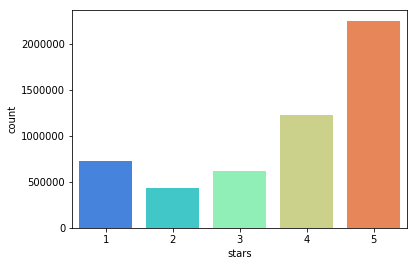

In [7]:
sns.countplot(x='stars', data=reviews, palette='rainbow')
plt.show()

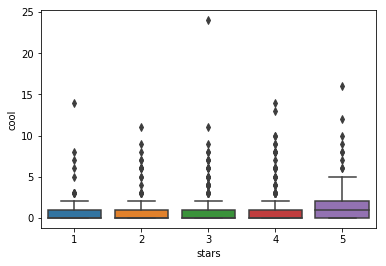

In [8]:
sns.boxplot(x=reviews['stars'][0:1000], y=reviews['cool'][0:1000])
plt.show()

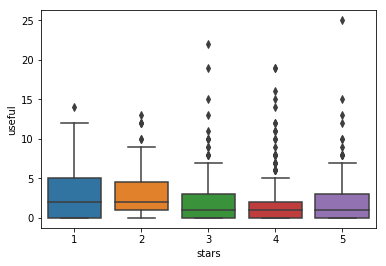

In [9]:
sns.boxplot(x=reviews['stars'][0:1000], y=reviews['useful'][0:1000])
plt.show()

In [10]:
reviews['length']= reviews['text'].apply(len)   #.map(lambda x: len(x))

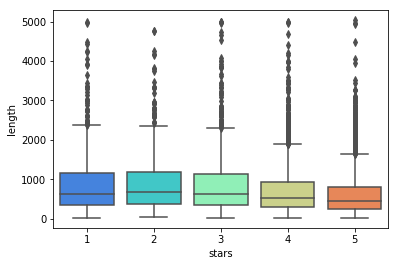

In [11]:
sns.boxplot(x=reviews['stars'][1:10000], y=reviews['length'][1:10000], palette='rainbow')
plt.show()

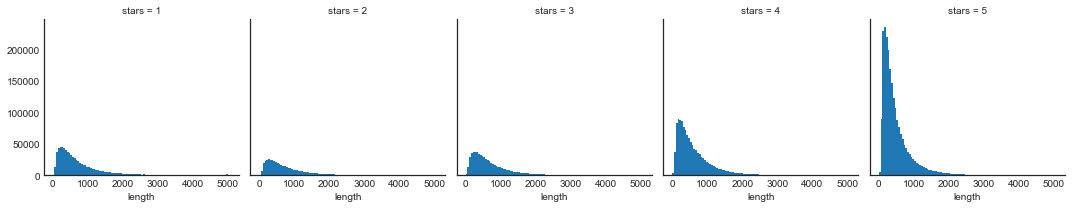

In [12]:
sns.set_style('white')
g=sns.FacetGrid(reviews, col='stars')
g.map(plt.hist, 'length', bins=100)
plt.show()

In [13]:
reviews.groupby('stars').mean()

,useful,funny,cool,length
stars,,,,
1,2.210875,0.707292,0.279544,764.181383
2,1.625610,0.668248,0.415523,769.211320
3,1.341018,0.614906,0.646093,716.108068
4,1.349785,0.567573,0.824651,631.355725
5,1.101492,0.353408,0.572854,492.783366


In [14]:
featureCorr=reviews.groupby('stars').mean().corr()
featureCorr

,useful,funny,cool,length
useful,1.000000,0.797196,-0.767887,0.750374
funny,0.797196,1.000000,-0.442860,0.981430
cool,-0.767887,-0.442860,1.000000,-0.503737
length,0.750374,0.981430,-0.503737,1.000000


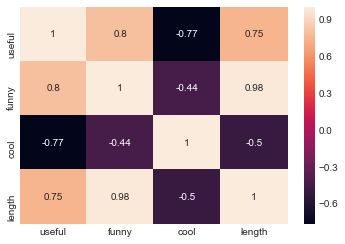

In [15]:
sns.heatmap(featureCorr, annot=True)
plt.show()

In [16]:
reviews['stars']=reviews['stars'].map({1:0, 2:0, 3:0, 4:1, 5:1})

In [17]:
from sklearn.model_selection import train_test_split
text_train, text_test, y_train, y_test = train_test_split(reviews['text'][0:100000], reviews['stars'][0:100000], 
                                                          test_size=0.3, shuffle=True, random_state=42)

In [18]:
reviews['stars'].value_counts()

1    3476663
0    1785005
Name: stars, dtype: int64

# Semantic analysis with tf-idf and N-grams using Naive Bayes model: 
    * Approach 1: without word normalization (i.e. lammatization or stemming)

In [19]:
# We find the best setting of n-gram range and logistic regression parameter using a grid search:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold


pipe = make_pipeline(TfidfVectorizer(min_df=10), 
                     MultinomialNB()) 

# running the grid search takes a long time because of the relatively large grid and the inclusion of trigrams 
param_grid = {"tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

kfold=StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
grid1 = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=kfold, scoring='f1') 
grid1.fit(text_train, y_train) 

G=pd.DataFrame(grid1.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidfvectorizer__ngram_range,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
2,69.061522,0.248069,15.402241,0.027599,"(1, 3)","{'tfidfvectorizer__ngram_range': (1, 3)}",0.908172,0.907967,0.908070,0.000103,1,0.930015,0.926841,0.928428,0.001587
1,37.272047,0.494461,22.683278,0.020428,"(1, 2)","{'tfidfvectorizer__ngram_range': (1, 2)}",0.906711,0.905771,0.906241,0.000470,2,0.925537,0.922514,0.924026,0.001511
0,13.670593,0.401951,12.197899,0.297762,"(1, 1)","{'tfidfvectorizer__ngram_range': (1, 1)}",0.892388,0.888797,0.890592,0.001795,3,0.903764,0.899849,0.901807,0.001957


In [20]:
print("Best parameters:\n{}".format(grid1.best_params_), '\n')
print("Best cross-validation score: {:.2f}".format(grid1.best_score_)) 
print("Test score: {:.2f}".format(grid1.score(text_test, y_test)))

Best parameters:
{'tfidfvectorizer__ngram_range': (1, 3)} 

Best cross-validation score: 0.91
Test score: 0.91


In [22]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

report=classification_report(y_test, grid1.predict(text_test), target_names=['1-3 stars', '4-5 stars'])
print(report)

             precision    recall  f1-score   support

  1-3 stars       0.93      0.70      0.80     10108
  4-5 stars       0.86      0.97      0.91     19892

avg / total       0.88      0.88      0.87     30000



Confusion matrix, without normalization
[[ 7053  3055]
 [  556 19336]]
Normalized confusion matrix
[[0.7  0.3 ]
 [0.03 0.97]]


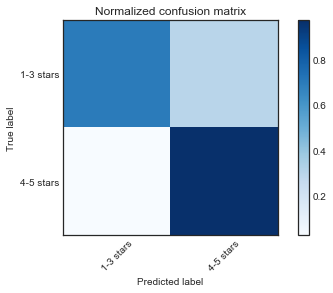

In [23]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["1-3 stars", "4-5 stars"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid1.predict(text_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

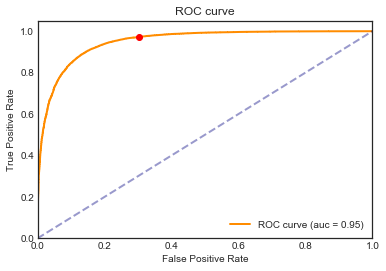

In [24]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid1.predict_proba(text_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid1.predict_proba(text_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()